# Pitcher's first movement


This notebook runs experiments on recognizing the pitcher's first movement with FMO-C. In this approach, a first movement is defined as a sequence of motion candidates close to the pitcher's leg.

The notebook contains the following steps:

* Load metadata and joint trajectories (for the leg position)
* Run FMO-C on a directory of video files - for each one, the first movement frame is outputted
* Display the results in a boxplot below (All results are saved in a json file)

### Specify path of input videos

In [1]:
import os

# This is a folder with more than 100 videos - can be exchanged with other dates!
PATH_VIDEOS = os.path.join("..", "train_data","ATL", "2017-05-04", "center field")

# Path to save outputs (first move frame for each video) as json file: 
# / does not need to exist yet
PATH_OUTPUTS = os.path.join("outputs", "first_move_result_dic")

# Path to already existing outputs (to overwrite results and for Evaluation (Boxplots)):
# / same in this case because I added the results all to the same dictionary
PATH_RESULTS = os.path.join("outputs", "first_move_result_dic")

### Imports

In [2]:
import numpy as np
import json
import cv2
import pandas as pd
from scipy import ndimage
import matplotlib.pylab as plt
import ast

In [3]:
# Load fmo_detection code from the parent directory (because it is used for object detection and event detection)
import sys
sys.path.append("..")
from fmo_detection import detect_ball, from_json

/Users/ninawiedemann/anaconda/envs/baseball_analysis3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 0. Run on one video

Specify path of input video, path of joint trajectories and the other parameters, then simly run the detect_ball() function

In [5]:
path_vid = os.path.join("..", "demo_data", "example_1.mp4")
path_joints = os.path.join("..", "demo_data", "example_1_pitcher.json")
joints = from_json(path_joints)
EVERY_K_FRAME = 3 # speed sensitivity
REFINE = True # refine output (find frame when the leg is highest)
MIN_AREA = 40 # regions of motion minimum area 
_, first_move_frame, _ = detect_ball(path_vid, joints_array = joints, plotting=False, min_area=MIN_AREA, every_x_frame= EVERY_K_FRAME, refine = REFINE) #400

## 1.  For multiple videos for evaluation: Load data and metadata: 

### Get metadata and joint trajectories from csv file:

Save joints for each video in a dictionary called joint_trajectories

Save metadata as a dictionary in another dictionary for each file, examplified in the output of the next cell.
Following metadata is saved:
* label (Statcast calculation of the Pitcher's first movement)
* Pitching position (Windup or Stretch, interesting because determines how fast the movement is)
* Ball release frame (important for evaluation later)

In [5]:
cf = pd.read_csv(os.path.join("..", "train_data", "cf_pitcher.csv"))
print(cf.columns.tolist())

file_list = os.listdir(PATH_VIDEOS)
i=0
game_id = file_list[i][:6]
while game_id[0]==".":
    i+=1
    game_id = file_list[i][:6]
print("Game id:", game_id)



joint_trajectories = {}
result_dic = {}

# replace missing values in the labels with the mean (does not happen often)
first_move_mean = cf["First move"].values
first_move_mean = first_move_mean[np.where(np.logical_not(pd.isnull(first_move_mean)))]
first_move_mean = np.mean(first_move_mean)

position_mean = "Windup"

release_mean = cf["pitch_frame_index"].values
release_mean = release_mean[np.where(np.logical_not(pd.isnull(release_mean)))]
release_mean = np.mean(release_mean)


for i in cf.index:
    play_id = cf.loc[i]["Game"]
    if play_id[:6]!=game_id:
        continue
    inner_dic = {}
    joint_trajectories[play_id] = np.array(eval(cf.loc[i]["Data"]))
    first_move_label = cf.loc[i]["First move"]
    if np.isnan(first_move_label):
        first_move_label = first_move_mean
    release_label = cf.loc[i]["pitch_frame_index"]
    if np.isnan(release_label):
        release_label = release_mean
    position_label = cf.loc[i]["Pitching Position (P)"]
    if pd.isnull(position_label):
        position_label = position_mean
    inner_dic["label"] = first_move_label
    inner_dic["release"] = release_label
    inner_dic["position"] = position_label
    result_dic[play_id] = inner_dic
    
example_file = list(joint_trajectories.keys())[0]
print("\nEXAMPLE: for file ", example_file)
print("Joint trajectory array: Shape:")
print(joint_trajectories[example_file].shape)
print("Dictionary with metadata:")
print(result_dic[example_file])

['Unnamed: 0', 'Game', 'Pitch Type', 'balls', 'prev_pitch_type', 'First move', 'handedness', 'Pitcher', 'pitch_frame_index', 'Pitching Position (P)', 'all outcomes', 'Play Outcome', 'Data']
Game id: 490770

EXAMPLES: for file  490770-00e403bc-66f1-467a-9a84-c72f7dfa45ab
Joint trajectory array: Shape:
(166, 12, 2)
Dictionary with metadata:
{'label': 44.0, 'release': 93.0, 'position': 'Windup'}


### To overwrite the results that were obtained in previous experiments, or add new configuration (of every_k_frame) to the results, load the corresponding file:

In [8]:
with open(PATH_RESULTS, "r") as infile:
    result_dic = json.load(infile)

### Settings: Set speed sensitivity (every k frame is taken to calculate the difference image) and if the output should be refined

In [6]:
EVERY_K_FRAME = 3
REFINE = False

if REFINE:
    save_name = str(EVERY_K_FRAME)+"_refined"
else:
    save_name = "every_"+str(EVERY_K_FRAME)

## 2. FMO-C: Run on all videos in the folder

### Outputs are saved in the result_dic, with the name corresponding to the setting specified above


 File: 490770-00e403bc-66f1-467a-9a84-c72f7dfa45ab.mp4
Loaded joints trajectory array with shape (166, 12, 2)
Detected first movement 66 , Statcast label 44.0
--> Error: 22.0


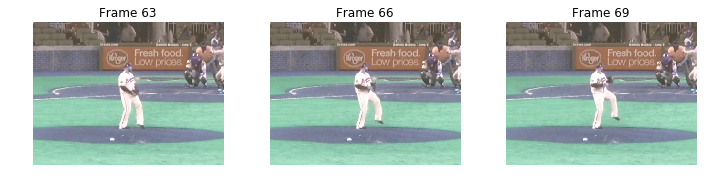


 File: 490770-03daf882-8539-4952-ae13-c924a1653a4d.mp4
Loaded joints trajectory array with shape (166, 12, 2)
Detected first movement 67 , Statcast label 15.0
--> Error: 52.0


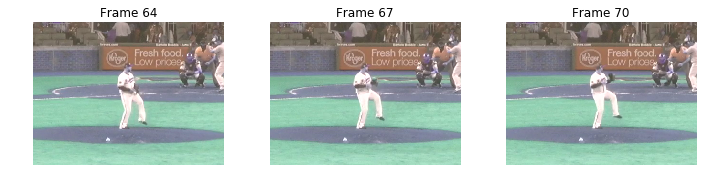


 File: 490770-0457bc47-249c-4027-ba35-a06141be4e02.mp4
Loaded joints trajectory array with shape (166, 12, 2)
Detected first movement 64 , Statcast label 60.0
--> Error: 4.0


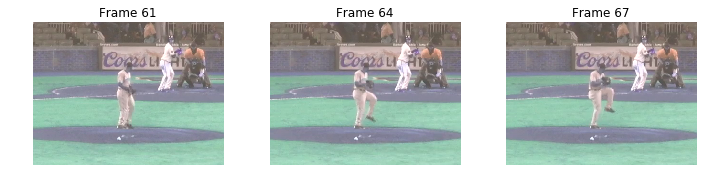


 File: 490770-04819dc2-e122-441c-840e-98601242e8a4.mp4
Loaded joints trajectory array with shape (166, 12, 2)


KeyboardInterrupt: 

In [7]:
def plot_result_frame(BASE, first_move_frame):
    """
    Plot first movement frame and one three frames before and three frames after
    """
    cap = cv2.VideoCapture(BASE)
    show_every = 3
    show_frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, first_move_frame-show_every)
    for k in range(2*show_every+1):
        ret,frame = cap.read()
        if k%show_every==0:
            show_frames.append(frame)
    
    fig = plt.figure(figsize=(10, 5))
    for ind, i in enumerate(show_frames):
        ax = fig.add_subplot(1,len(show_frames),ind+1)
        plt.imshow(i[100:400, 200:600])
        plt.title("Frame "+str(first_move_frame-show_every+ind*show_every))
        plt.grid(False)
        plt.axis('off')
        plt.gray()
    plt.tight_layout()
    plt.show()
    

j = 0
for bsp in file_list:
    if bsp[-4:]!=".mp4" or bsp[0]==".":
        continue
    play_id = bsp[:-4]
    BASE = os.path.join(PATH_VIDEOS, bsp) # "/Volumes/Nina Backup/CENTERFIELD bsp videos/3d69a818-568e-4eef-9d63-24687477e7ee.mp4" # minarea 50
    print("\n File:", bsp)
    
    joints = joint_trajectories[play_id][:,:12,:]
    print("Loaded joints trajectory array with shape", joints.shape)

    _, first_move_frame, _ = detect_ball(BASE, joints_array = joints, plotting=False, min_area=50, every_x_frame= EVERY_K_FRAME, refine = REFINE) #400

    if first_move_frame==0: # NO FIRST MOVEMENT FOUND --> PUT 160 as output
        result_dic[play_id][save_name] = float(160)
        print("Error: No first movmenet frame found")
        continue
    result_dic[play_id][save_name] = float(first_move_frame)
    print("Detected first movement", first_move_frame, ", Statcast label", result_dic[play_id]["label"])
    print("--> Error:", abs(first_move_frame - result_dic[play_id]["label"]))
    
    j+=1
    
    plot_result_frame(BASE, first_move_frame)

### Save results

In [7]:
with open(PATH_OUTPUTS, "w") as outfile:
    json.dump(result_dic, outfile)

# 3. Evaluation

In [8]:
with open(PATH_RESULTS, "r") as infile:
    result_dic = json.load(infile)

### convert to lists

In [9]:
dic = {"position": [], "3_refined": [], "1_refined": [], "2_refined": [],"4_refined": [], "release": [], "every_3":[],"every_1":[], "label":[], "every_4":[], "every_2":[], "every_5":[], "5_refined":[]}
for key in result_dic.keys():
    for sub_key in result_dic[key].keys():
        dic[sub_key].append(result_dic[key][sub_key])

###  Boxplots

['k=3 refined', 'k=1 refined', 'k=2 refined', 'k=4 refined', 'k=3', 'k=1', 'Statcast', 'k=4', 'k=2', 'k=5', 'k=5 refined']
('Statcast', 'k=1', 'k=1 refined', 'k=2', 'k=2 refined', 'k=3', 'k=3 refined', 'k=4', 'k=4 refined', 'k=5', 'k=5 refined') (6, 5, 1, 8, 2, 4, 0, 7, 3, 9, 10)


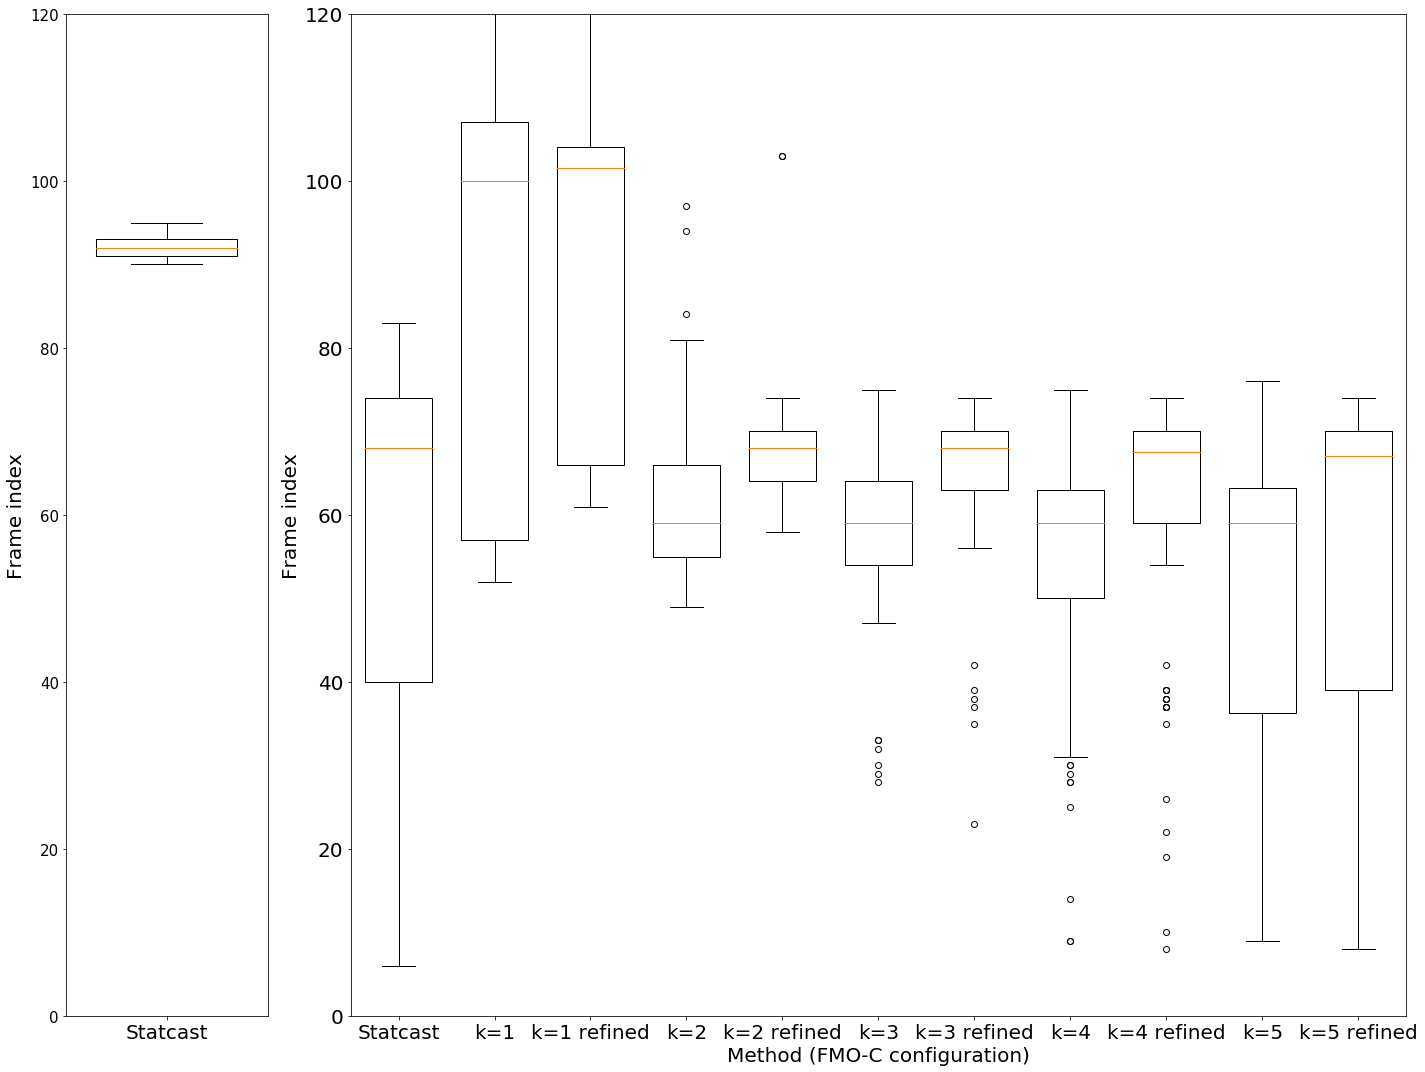

In [10]:
import pandas as pd
# path = "all_first_move_tests.json"
#path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/3_Event_detection/all_first_move_tests.json"
#with open(path, "r") as infile:
 #   dic = json.load(infile)
#print(dic.keys())

plt.figure(figsize=(20,15))
# gs = gridspec_kw = {'width_ratios':[1, 5]}
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 5)
plt.subplot(gs[0,0])
plt.boxplot(dic["release"], positions= [0], widths=(0.7))
plt.xticks([0], ["Statcast"], fontsize=20)
plt.yticks(fontsize=15)
    # plt.title(lab)
plt.ylabel("Frame index", fontsize=20)
# plt.title("Release frame", fontsize=15)
plt.ylim(0,120)
    # i+=1
# plt.show()
plt.subplot(gs[0,1:])
i=0
liste=[]
l2=[]
for key in dic.keys():
    if dic[key]==[]:
        continue
    if "every" in key:
        lab = "k="+key[-1]
    elif key=="label":
        lab = "Statcast"
    elif key=="release":
        continue
        lab = "release frame"
    elif key[2:]=="refined":
        lab = "k="+key[0]+" refined"
    else:
        continue
    # plt.subplot(1, len(dic.keys())-1,i+1)
    l2.append(lab)
    liste.append(dic[key])
print(l2)

# Sort list
from operator import itemgetter
inds, l2 = zip(*sorted(enumerate(l2), key=itemgetter(1)))
print(l2, inds)
new_list = []
for i in inds:
    new_list.append(liste[i])
#liste = np.array(liste)[inds]
liste = new_list
# l2=l2[inds]
plt.boxplot(liste, positions=np.arange(len(liste)), widths=tuple([0.7 for _ in range(len(liste))]))
plt.xticks(range(0, len(l2), 1), l2, fontsize=20)
plt.yticks(fontsize=20)
    # plt.title(lab)
plt.ylabel("Frame index", fontsize=20)
plt.ylim(0,120)
# plt.title("Pitcher's first movement", fontsize=15)
    # i+=1
plt.xlabel("Method (FMO-C configuration)", fontsize=20)
plt.tight_layout()
plt.show()

### Explanation:

The output of FMO-C first movement detection is the frame index of the pitcher's first movement.  Each data point corresponds to one video, which contains about 160 frames. Ball release always occurs around frame 90, at least in the metadata from the Statcast system who measure the release frame via radar. (Left figure)

However, the labels for the first movement that are provided by Statcast are quite inaccurate, as shown on the left of the second plot. The outputs vary widely, which is not realistic considering that the pitcher's movement is of very constant speed. We tested FMO-C for first movement detection on more than hundred videos, and varied the speed sensitivity k: If k=4 for example, only every fourth frame is taken into account and thus more motion is detected. In the plot you can see that the higher k, the earlier the movement is detected. An appropriate level would be k=3 because only some outliers occur, and it is better to have a first movement too early than too late. 

Refining the outputs makes the variance even smaller, because only the moment that the pitcher's leg is highest is found

### Other visualizations of the outputs (Only works if run for all videos)

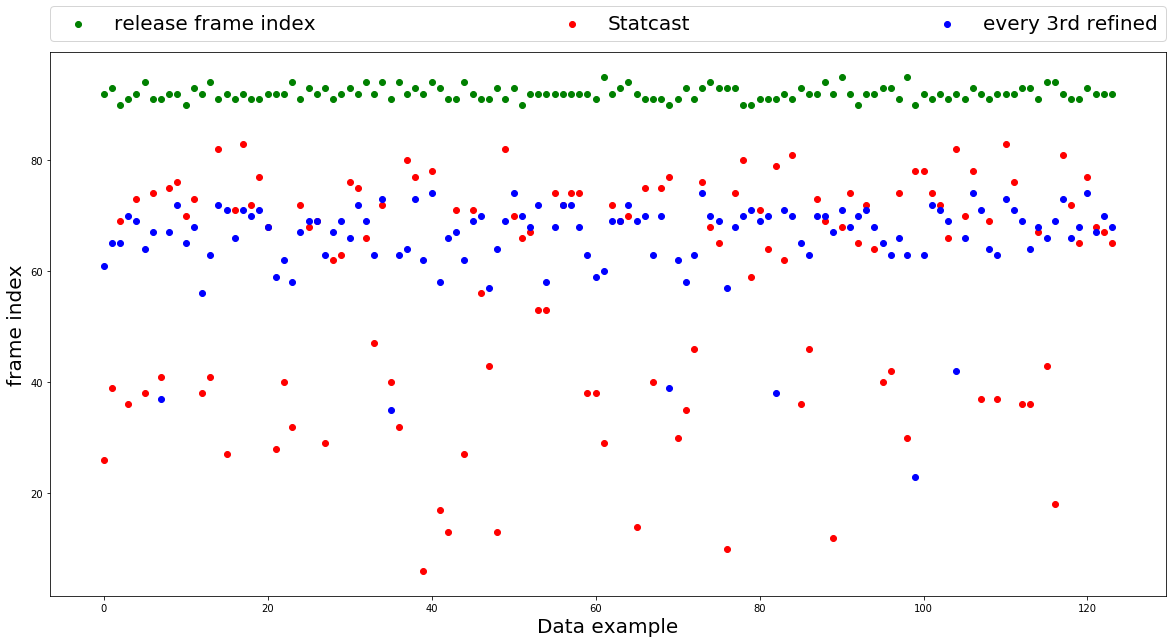

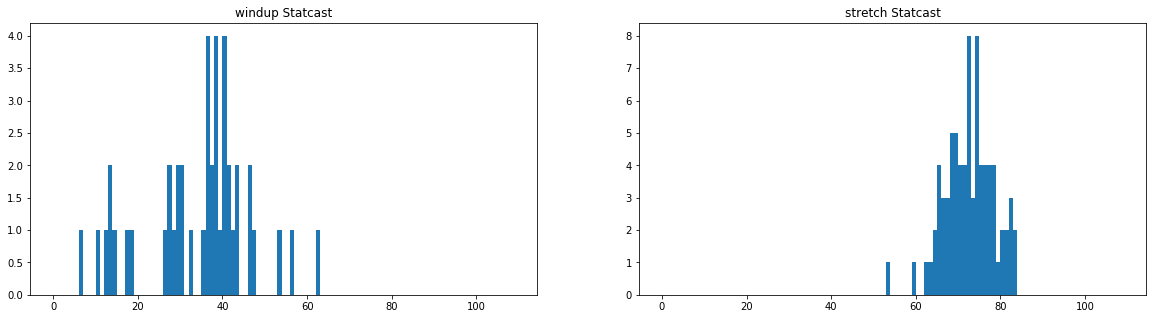

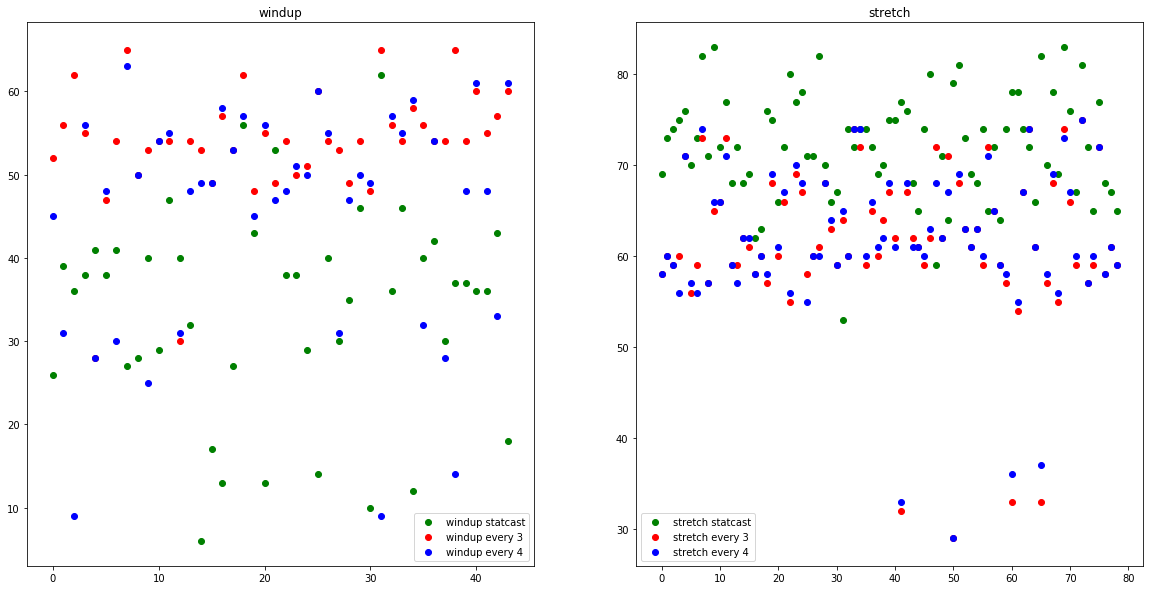

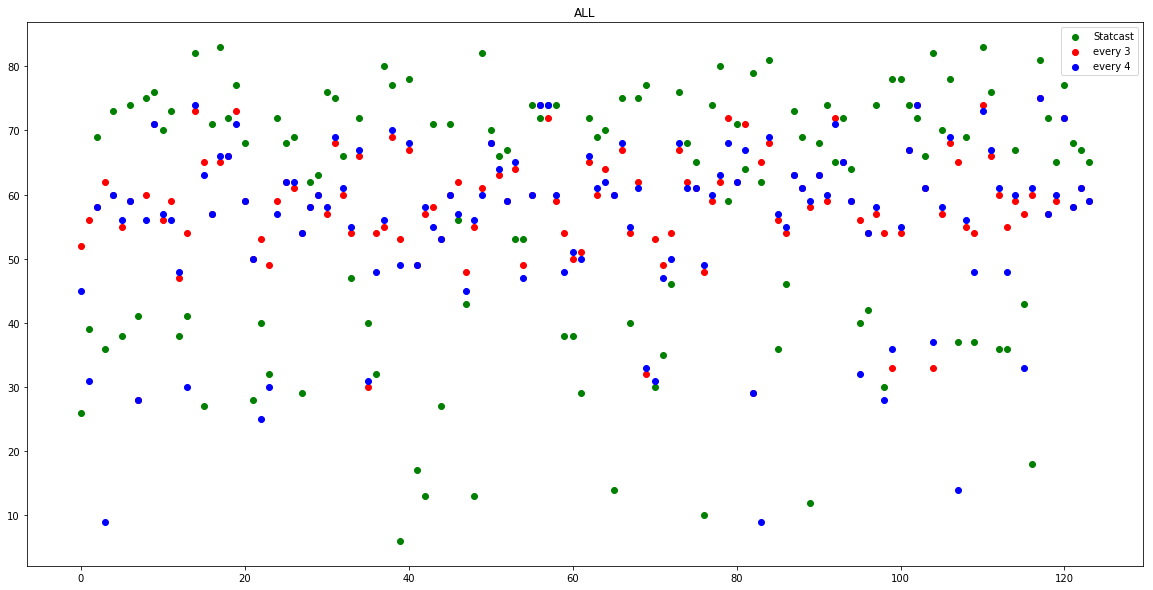

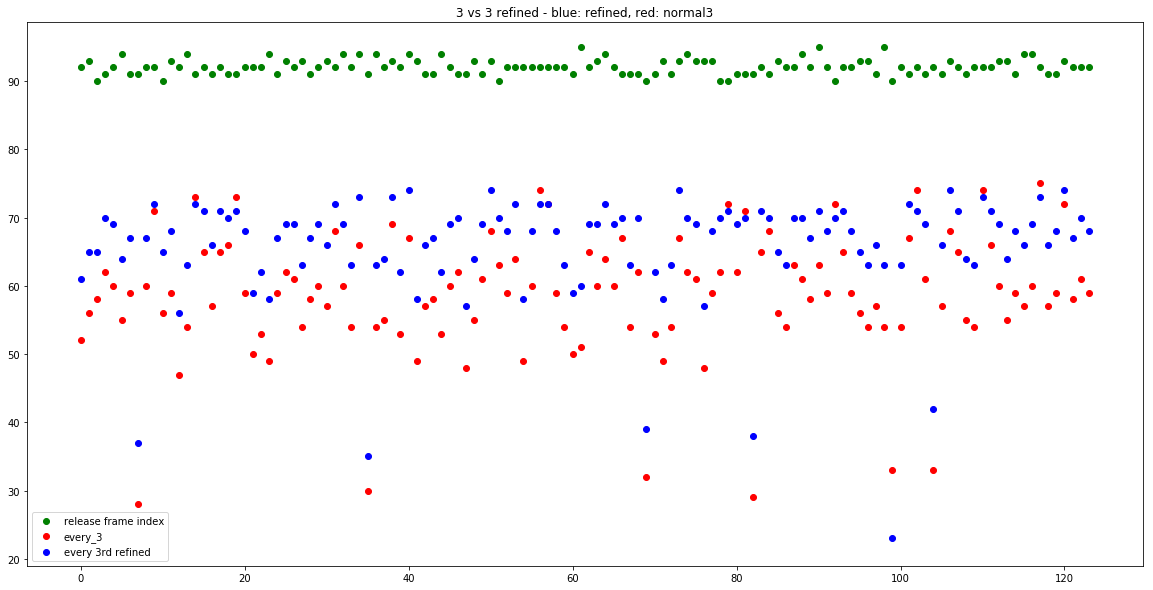

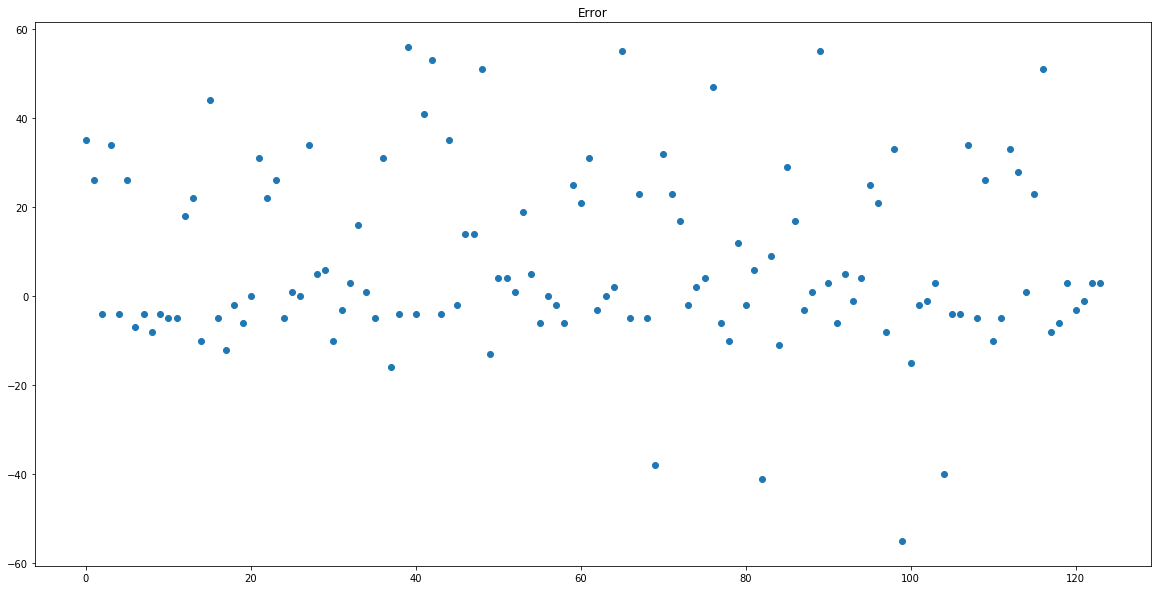

Mean error 7.51612903226


In [11]:
# print(np.array(outputs).shape)
# new = np.array(outputs)[:, 0, :]
#new = np.append(np.array([outputs[0][1], outputs[0][2]]), np.array(new), axis = 0)
def scatter_plot(l, plotting_labels):
    plt.scatter(np.arange(len(l[0])),l[0], label = plotting_labels[0], c = "green")
    plt.scatter(np.arange(len(l[0])), l[1], label = plotting_labels[1], c = "red")
    plt.scatter(np.arange(len(l[0])), l[2], label = plotting_labels[2], c="blue")


# COMPARE labels and 3 refined_nograd:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["label"], dic["3_refined"]], ["release frame index", "Statcast", "every 3rd refined"])
# plt.title("label vs 3 refined - blue: refined, red: label")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., fontsize=20)
plt.xlabel("Data example", fontsize=20)
plt.ylabel("frame index", fontsize=20)
plt.show()


# SHOW LABELS SEPERATED BY WINDUP AND STRETCH
inds = np.where(np.array(dic["position"])=="Windup")[0]
inds_st = np.where(np.array(dic["position"])=="Stretch")[0]
vals_wind = np.array(dic["label"])[inds]
vals_stretch = np.array(dic["label"])[inds_st]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(vals_wind, bins= np.arange(0, 110))
plt.title("windup Statcast")
plt.subplot(1,2,2)
plt.hist(vals_stretch, bins= np.arange(0, 110))
plt.title("stretch Statcast")
plt.show()

# WINDUP
every_3_wind = np.array(dic["every_3"])[inds]
every_4_wind =  np.array(dic["every_4"])[inds]
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
plt.subplot(1,2,1)
scatter_plot([vals_wind, every_3_wind, every_4_wind], ["windup statcast", "windup every 3", "windup every 4"])
plt.title("windup")
plt.legend()
# plt.show()

# STRETCH
every_3_set = np.array(dic["every_3"])[inds_st]
every_4_set =  np.array(dic["every_4"])[inds_st]
# plt.style.use('ggplot')
plt.subplot(1,2,2)
scatter_plot([vals_stretch, every_3_set, every_4_set], ["stretch statcast", "stretch every 3", "stretch every 4"])
plt.title("stretch")
plt.legend()
plt.show()

# ALL
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
scatter_plot([dic["label"], dic["every_3"], dic["every_4"]], ["Statcast", "every 3", "every 4"])
plt.legend()
plt.title("ALL")
plt.legend()
plt.show()
#plt.grid(True)
#from matplotlib2tikz import save as tikz_save
#tikz_save('test.tex')

# COMPARE 3 and 3 refined:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["every_3"], dic["3_refined"]], ["release frame index", "every_3", "every 3rd refined"])
plt.title("3 vs 3 refined - blue: refined, red: normal3")
plt.legend()
plt.show()



# DIFFERENCE FROM EACH OTHER
fig = plt.figure(figsize = (20,10))
label_error = np.array(dic["3_refined"])-np.array(dic["label"])
plt.scatter(np.arange(0,len(label_error),1), label_error)
plt.title("Error")
plt.show()
print("Mean error", np.mean(label_error))